Para graficar una curva de validación modificando alguno de los hiperparámetros primero modificamos la función de k-fold para que devuelva directamente el promedio y el desvío estándar.

In [ ]:
from tree import CART
import numpy as np 

def k_fold_cross_validation(X, y, k=5, max_depth=None, min_samples_split=2, min_samples_leaf=1, seed=40):
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.seed(seed)
    np.random.shuffle(indices)  # Mezclar datos

    fold_sizes = np.full(k, n_samples // k, dtype=int)
    fold_sizes[: n_samples % k] += 1  # Repartir sobrantes
    current = 0

    scores_val = []
    scores_train = []

    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = indices[start:stop]
        train_idx = np.concatenate((indices[:start], indices[stop:]))

        X_train_fold, y_train_fold = X[train_idx], y[train_idx]
        X_val_fold, y_val_fold = X[val_idx], y[val_idx]

        # Entrenar árbol
        tree = CART(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
        tree.fit(X_train_fold, y_train_fold)

        # Predecir en entrenamiento y validación
        y_pred_val = tree.predict(X_val_fold)
        y_pred_train = tree.predict(X_train_fold)
        acc_val = np.mean(y_pred_val == y_val_fold)
        acc_train = np.mean(y_pred_train == y_train_fold)
        scores_val.append(acc_val)
        scores_train.append(acc_train)

        current = stop

    train = np.mean(scores_train)
    val = np.mean(scores_val)
    desvtrain = np.std(scores_train)
    desvval = np.std(scores_val)

    return train, val, desvtrain, desvval


Tomando distintos valores para _max_depth_ y dejando fijos _min_samples_split = 5_ y _min_samples_split = 2_:

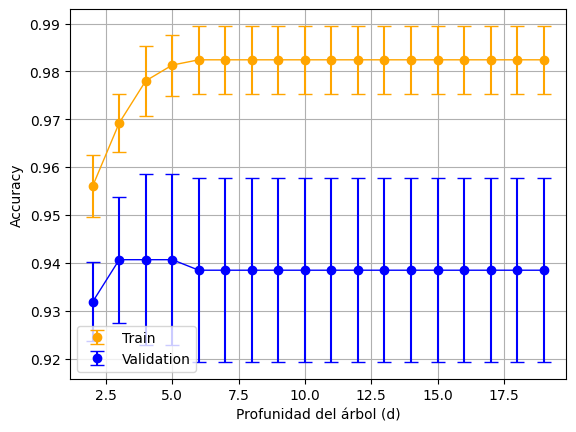

In [4]:
from data import X_train, y_train
import matplotlib.pyplot as plt

train = []
val = []
desvtrain = []
desvval = []

depth_values = list(range(2,20))

for i in depth_values:
    s_train, s_val, s_desvtrain, s_desvval = k_fold_cross_validation(X_train, y_train, k=5, max_depth=i, min_samples_split=5, min_samples_leaf=2)
    train.append(s_train)
    val.append(s_val)
    desvtrain.append(s_desvtrain)
    desvval.append(s_desvval)

plt.errorbar(depth_values, train, yerr=desvtrain, fmt="o", capsize=5, label="Train", color="orange")
plt.errorbar(depth_values, val, yerr=desvval, fmt="o", capsize=5, label="Validation", color="blue")
plt.plot(depth_values, train, linewidth=1, color="orange")
plt.plot(depth_values, val, linewidth=1, color="blue")
plt.xlabel("Profunidad del árbol (d)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

En este caso se observa la forma esperada para un gráfico de accuracy en función de la profunidad del árbol, donde el árbol alcanza su profunidad máxima (en este caso en _d=6_), sea porque las hojas llegan a un valor de impureza igual a 0 o porque alguno de los otros criterios de corte se satisface.

Para hacer una grid search combinando dos hiperparámetros, se puede proceder de manera similar, agregando también la posibilidad de que _min_samples_leaf_ tome varios valores y fijando _min_samples_split_ (en este caso en 0, para que no limite a los otros dos parámetros).

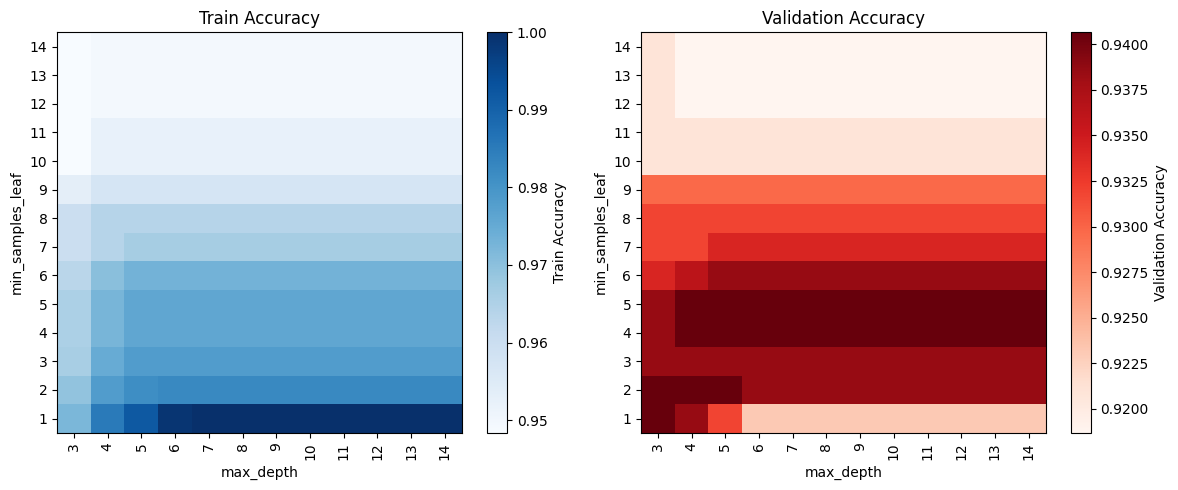

In [13]:
depth_values = list(range(3, 15))
leaf_values = list(range(1, 15))

# Para guardar resultados
results = {}

for depth in depth_values:
    for leaf in leaf_values:
        s_train, s_val, s_desvtrain, s_desvval = k_fold_cross_validation(
            X_train, y_train,
            k=5,
            max_depth=depth,
            min_samples_split=0,
            min_samples_leaf=leaf
        )
        results[(depth, leaf)] = {
            "train_mean": s_train,
            "val_mean": s_val,
            "train_std": s_desvtrain,
            "val_std": s_desvval
        }

# Convertimos a arrays para graficar heatmaps
train_acc = np.array([[results[(d, l)]["train_mean"] for d in depth_values] for l in leaf_values])
val_acc   = np.array([[results[(d, l)]["val_mean"]   for d in depth_values] for l in leaf_values])

plt.figure(figsize=(12, 5))

# Heatmap train
plt.subplot(1, 2, 1)
plt.imshow(train_acc, aspect="auto", cmap="Blues", origin="lower")
plt.xticks(ticks=np.arange(len(depth_values)), labels=depth_values, rotation=90)
plt.yticks(ticks=np.arange(len(leaf_values)), labels=leaf_values)
plt.colorbar(label="Train Accuracy")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Train Accuracy")

# Heatmap validation
plt.subplot(1, 2, 2)
plt.imshow(val_acc, aspect="auto", cmap="Reds", origin="lower")
plt.xticks(ticks=np.arange(len(depth_values)), labels=depth_values, rotation=90)
plt.yticks(ticks=np.arange(len(leaf_values)), labels=leaf_values)
plt.colorbar(label="Validation Accuracy")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()


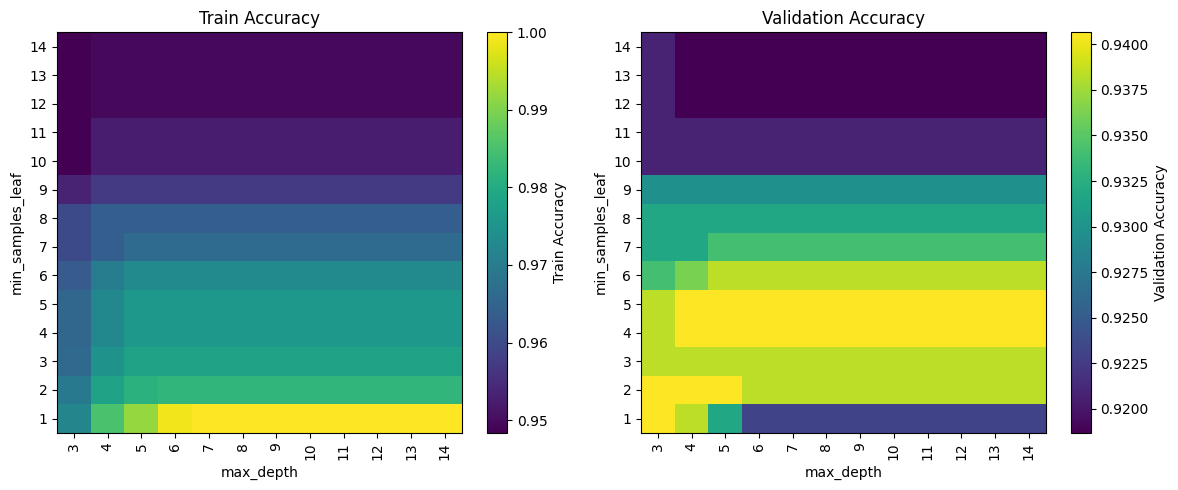

In [ ]:
plt.figure(figsize=(12, 5))

# Heatmap train
plt.subplot(1, 2, 1)
plt.imshow(train_acc, aspect="auto", cmap="viridis", origin="lower")
plt.xticks(ticks=np.arange(len(depth_values)), labels=depth_values, rotation=90)
plt.yticks(ticks=np.arange(len(leaf_values)), labels=leaf_values)
plt.colorbar(label="Train Accuracy")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Train Accuracy")

# Heatmap validation
plt.subplot(1, 2, 2)
plt.imshow(val_acc, aspect="auto", cmap="viridis", origin="lower")
plt.xticks(ticks=np.arange(len(depth_values)), labels=depth_values, rotation=90)
plt.yticks(ticks=np.arange(len(leaf_values)), labels=leaf_values)
plt.colorbar(label="Validation Accuracy")
plt.xlabel("max_depth")
plt.ylabel("min_samples_leaf")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

Así, se observa cómo para los datos de entrenamiento, la accuracy aumenta a medida que aumenta la profunidad del árbol (como ya se había observado previamente) para un valor de _min_samples_leaf = 1_

Sin embargo, para el conjunto de validación, además de aumentar la accuracy con la profundidad del árbol, esta también se maximiza para valores de _min_samples_leaf = 4_ y 5.

Comparando estos resultados con los obtenidos para los árboles entrenados en el apartado 2, vemos que efectivamente era posible obtener una mejor combinación de hiperpármetros, ya que originalmente habíamos seleccionado _max_depth = 10_ y _min_samples_leaf = 2_, combinación que no está comprendida dentro de la región óptima para la accuracy de los datos de validación.